<a href="https://colab.research.google.com/github/projectyumo/deepfovia/blob/master/COLAB_fovia_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Get supporting libraries and download sample data**


In [9]:
!git clone https://github.com/ouyangzhibo/Image_Foveation_Python
!pip install youtube-dl
!youtube-dl https://www.youtube.com/watch?v=eG7TCRs2oas
!mv 'Jeep Wrangler - Forza Horizon 4 _ Logitech g29 gameplay-eG7TCRs2oas.mp4' test_vid.mp4

Cloning into 'Image_Foveation_Python'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 55 (delta 0), reused 2 (delta 0), pack-reused 52
Unpacking objects: 100% (55/55), done.
     |████████████████████████████████| 1.8MB 4.7MB/s 
[youtube] eG7TCRs2oas: Downloading webpage
[download] Destination: Jeep Wrangler - Forza Horizon 4 _ Logitech g29 gameplay-eG7TCRs2oas.f137.mp4
[download] 100% of 345.06MiB in 00:12
[download] Destination: Jeep Wrangler - Forza Horizon 4 _ Logitech g29 gameplay-eG7TCRs2oas.f140.m4a
[download] 100% of 9.42MiB in 00:00
[ffmpeg] Merging formats into "Jeep Wrangler - Forza Horizon 4 _ Logitech g29 gameplay-eG7TCRs2oas.mp4"
Deleting original file Jeep Wrangler - Forza Horizon 4 _ Logitech g29 gameplay-eG7TCRs2oas.f137.mp4 (pass -k to keep)
Deleting original file Jeep Wrangler - Forza Horizon 4 _ Logitech g29 gameplay-eG7TCRs2oas.f140.m4a (pass -k to keep)


**Import Python Libraries**

In [1]:
from PIL import Image 
import glob, random, os
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.nn.utils import spectral_norm
import torch.nn.functional as nnf

**Extract indivdual frames**
**30 fps for 10 seconds **


In [10]:
def video_to_frames(video_path, video_name):
    video = cv2.VideoCapture(video_path)
    success, image = video.read()
    count = 0

    # Save Frames into Train and Test Folders
    # 7 Seconds of frames at 30fps -> Train
    # 3 Seconds of frames at 30fps -> Test
    # Get frames from 0:20-0:30 
    while success and count <30*30:
        if count > 20*30 and count < 27*30: cv2.imwrite(os.path.join(video_name,'train/%d.png' % count), image)
        elif count >= 27*30: cv2.imwrite(os.path.join(video_name,'test/%d.png' % count), image)
        success, image = video.read()
        #print('Reading frame: ', count)
        count+=1
    
video_file = 'test_vid.mp4'

video_name = video_file[:-4]
if not os.path.isdir(video_name): os.mkdir(video_name) 
if not os.path.isdir(os.path.join(video_name,'test')):
  os.mkdir(os.path.join(video_name,'test')) 
  os.mkdir(os.path.join(video_name,'train'))
video_to_frames(video_file, video_name)

len(glob.glob(os.path.join(os.path.join(video_name,'test'), '*.png')))

90

**Foveate Images**

In [11]:
import subprocess 

frame_dir = ['test_vid/train/', 'test_vid/test/']
run_foveate = 1

for dir in frame_dir:
    frames = glob.glob(os.path.join(dir, '*.png'))
    for frame in frames:
        name = frame[len(dir):-4]
        foveate = 'python /content/Image_Foveation_Python/retina_transform.py /content/{}/{}.png'.format(dir, name).split(' ')
        if run_foveate==1: subprocess.call(foveate)

    frames = [int(frame[len(dir):-4]) for frame in frames]
    print(min(frames), max(frames))

601 809
810 899


**Sample Foveation**

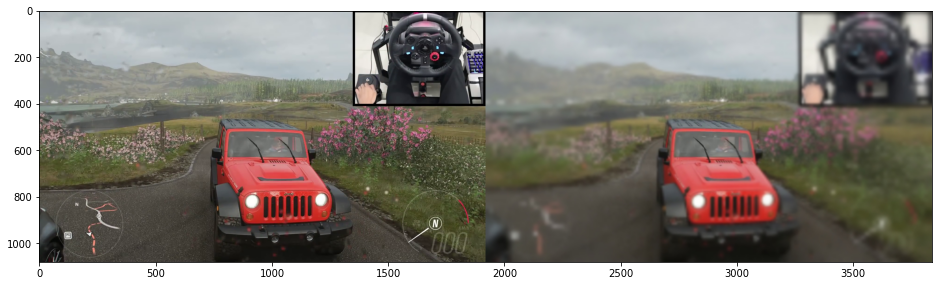

In [12]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

r_img = Image.open("/content/test_vid/train/750.png")
f_img = Image.open("/content/test_vid/train/750_RT.jpg")

cat_img = get_concat_h(r_img, f_img)

plt.figure(figsize=(16,8))
plt.imshow(cat_img)

**Create Dataloader**

In [2]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 frames_dir='test_vid/train', 
                 num_in_frames=4, 
                 transforms=transforms.Compose([transforms.ToTensor()]), 
                 img_size=256):
        
        self.img_size = img_size
        self.num_in_frames = num_in_frames
        self.transforms = transforms
        self.r_frames = sorted(glob.glob(os.path.join(frames_dir,'*.png')))
        self.f_frames = sorted(glob.glob(os.path.join(frames_dir,'*.jpg')))

    def __getitem__(self, index):
        imgs = []
        for frame in self.f_frames[index:index+self.num_in_frames]:
            imgs.append(transforms.ToTensor()(Image.open(frame).resize((self.img_size,self.img_size))))
        prior = torch.cat(imgs)

        goal = transforms.ToTensor()(Image.open(self.r_frames[index+self.num_in_frames]).resize((self.img_size,self.img_size)))

        return {'X':prior, 'Y':goal}

    def __len__(self):
        return len(self.r_frames)-self.num_in_frames

In [4]:
in_frames = 2
batch_size = 2

train_dataloader = torch.utils.data.DataLoader(VideoDataset(frames_dir='test_vid/train',img_size=1024,num_in_frames=in_frames,),
                                              batch_size=batch_size,
                                              shuffle=True)
test_dataloader = torch.utils.data.DataLoader(VideoDataset(frames_dir='test_vid/test',img_size=1024,num_in_frames=in_frames,),
                                              batch_size=batch_size,
                                              shuffle=False)

sample_batch = next(iter(train_dataloader))
X = sample_batch['X']
Y = sample_batch['Y']

In [10]:
print('X Shape:', X.shape)
print('Y Shape:', Y.shape)

X Shape: torch.Size([2, 6, 1024, 1024])
Y Shape: torch.Size([2, 3, 1024, 1024])


**Create Models**

In [5]:
class CNN(torch.nn.Module):
    def __init__(self, nc, nfm, img_size):
        super(CNN, self).__init__()

        exp = int( math.log(img_size)/math.log(2) )

        self.cnn = [spectral_norm(nn.Conv2d(nc, nfm, 4, 2, 1)),
                   nn.ReLU()]

        for i in range(exp-3):
          self.cnn += [spectral_norm(nn.Conv2d( nfm*(2**i) , nfm*( 2**(i+1) ), 4, 2, 1)),
                      nn.ReLU()]

        self.cnn += [spectral_norm(nn.Conv2d( nfm*( 2**(exp-3) ) , 1, 4, 1, 0)),
                    nn.Sigmoid()]

        self.cnn = nn.Sequential(*self.cnn)

    def forward(self, inputs):
        return self.cnn(inputs)

class ResidualBlock(torch.nn.Module):
    def __init__(self, nfm):
        super(ResidualBlock, self).__init__()

        self.conv_block = nn.Sequential(
          spectral_norm(nn.Conv2d(nfm, nfm, 3, 1, 1)),
          nn.BatchNorm2d(nfm),
          nn.ReLU(),
          spectral_norm(nn.Conv2d(nfm, nfm, 3, 1, 1)),
          nn.BatchNorm2d(nfm)
        )

        self.relu = nn.ReLU()

    def forward(self, x):
        result = x + self.conv_block(x)
        out = self.relu(result)
        return out

class ResNet(torch.nn.Module):
    def __init__(self, nfm, layers):
        super(ResNet, self).__init__()

        self.resnet = []
        for _ in range(layers):
            self.resnet += [ResidualBlock(nfm)]

        self.resnet = nn.Sequential(*self.resnet)

    def forward(self, x):
        return self.resnet(x)


class U_Net_Block(torch.nn.Module):
    def __init__(self, submodule, nfm=64, in_frames=None, out_frames=None, outermost=False, innermost=False):
        super(U_Net_Block, self).__init__()

        self.outermost = outermost
        self.innermost = innermost
        self.nfm = nfm
        

        if outermost:
            in_down_nc = in_frames*3
            out_up_nc = out_frames*3
        else:
            in_down_nc = nfm
            out_up_nc = nfm
        
        downconv_1 = spectral_norm(nn.Conv2d(in_down_nc, in_down_nc, 3, 1, 1))
        downnorm_1 = nn.BatchNorm2d(in_down_nc)

        downconv = spectral_norm(nn.Conv2d(in_down_nc, nfm*2, 3, 2, 1))
        downnorm = nn.BatchNorm2d(nfm*2)

        #upconv = nn.ConvTranspose2d(nfm*2*2, out_up_nc, 4, 2, 1)
        # *5 because (2*2): from skip connection + 1 from recurrent input

        upconv_1 = nn.ConvTranspose2d(nfm*4, nfm*4, 3, 1, 1)
        upnorm_1 = nn.BatchNorm2d(nfm*4)

        upconv = nn.ConvTranspose2d(nfm*4, out_up_nc*2, 3, 2, 0)
        upnorm = nn.BatchNorm2d(out_up_nc*2)

        relu = nn.ReLU()
        tanh = nn.Tanh()

        if outermost:
            upconv_1 = nn.ConvTranspose2d(nfm*4, nfm*4, 3, 1, 1)
            # upconv_2 = nn.ConvTranspose2d(nfm*4, nfm*4, 3, 1, 0)
            # upconv_3 = nn.ConvTranspose2d(nfm*4, nfm*4, 3, 1, 0)
            upnorm = nn.BatchNorm2d(nfm*4)

            upconv = nn.ConvTranspose2d(nfm*4, out_up_nc, 3, 2, 1)

            down = [downconv_1, downnorm_1, relu, downconv, downnorm, relu]
            up = [upconv_1, upnorm, relu, upconv, tanh]
        elif innermost:
            res_nfm = 64
            
            downconv_1 = spectral_norm(nn.Conv2d(nfm, nfm, 3, 1, 1))
            downnorm_1 = nn.BatchNorm2d(nfm)

            downconv = spectral_norm(nn.Conv2d(nfm, res_nfm, 3, 2, 1))
            downnorm = nn.BatchNorm2d(res_nfm)

            upconv_1 = nn.ConvTranspose2d(res_nfm, res_nfm, 3, 1, 1)
            upnorm_1 = nn.BatchNorm2d(res_nfm)

            upconv = nn.ConvTranspose2d(res_nfm, out_up_nc, 3, 2, 0)
            upnorm = nn.BatchNorm2d(out_up_nc)

            down = [downconv_1, downnorm_1, relu, downconv, downnorm, relu]
            up = [upconv_1,  upnorm_1, relu, upconv, upnorm, relu]
        else:
            downconv_1 = spectral_norm(nn.Conv2d(in_down_nc*2, in_down_nc*2, 3, 1, 1))
            downnorm_1 = nn.BatchNorm2d(in_down_nc*2)

            downconv =spectral_norm( nn.Conv2d(in_down_nc*2, nfm*2, 3, 2, 1))

            down = [downconv_1, downnorm_1, relu, downconv, downnorm, relu]
            up = [upconv_1, upnorm_1, relu, upconv, upnorm, relu]

        self.u_block = down + [submodule] + up
        self.u_block = nn.Sequential(*self.u_block)
                
    def forward(self, x):
        #print('initial x shape: ', x.shape)
        if self.outermost:
            #print('augmented shape: ', x.shape )
            return self.u_block(x)
        elif not self.innermost:
            hidden_idx = int(np.log2(1024//x.shape[2])-1)
            cat_recurrent = torch.cat([self.hidden[hidden_idx], x], 1)
            u_out = self.u_block(cat_recurrent)
            u_out = nnf.interpolate(u_out, size=(x.shape[2], x.shape[2]), mode='bilinear', align_corners=False)
            cat_feature_layers = torch.cat([x, u_out], 1)
            self.hidden = self.hidden[:hidden_idx] + [ cat_feature_layers[:, :x.shape[1], :, :] ] + self.hidden[hidden_idx+1:]
            
            return cat_feature_layers[:, x.shape[1]:, :, :]
            
        else:
            #print(x.shape, self.u_block(x).shape)
            cat_feature_layers = torch.cat([x, self.u_block(x)[:, :, :32, :32]], 1)
            #print('augmented shape: ', cat_feature_layers.shape )
            return cat_feature_layers
    
    def _init_hidden(self, batch_size):
        if torch.cuda.is_available(): self.hidden = [torch.zeros(batch_size, self.nfm, 512, 512).cuda(),
                                                     torch.zeros(batch_size, self.nfm, 256, 256).cuda(),
                                                     torch.zeros(batch_size, self.nfm, 128, 128).cuda(),
                                                     torch.zeros(batch_size, self.nfm, 64, 64).cuda()]
        else: self.hidden = [torch.zeros(batch_size, self.nfm, 512, 512),
                             torch.zeros(batch_size, self.nfm, 256, 256),
                             torch.zeros(batch_size, self.nfm, 128, 128),
                             torch.zeros(batch_size, self.nfm, 64, 64)]
        

class U_Net(torch.nn.Module):
    def __init__(self, nfm, base_network, in_frames, out_frames):
        super(U_Net, self).__init__()

        # ResNet Feature Maps: Res_Nfm x 16 x 16
        self.unet_in = U_Net_Block(base_network, nfm*16, innermost=True)
        # Unet: nfm*4 x 32 x 32
        self.unet_mid4 = U_Net_Block(self.unet_in, nfm*8)
        # Unet: nfm*2 x 64 x 64
        self.unet_mid3 = U_Net_Block(self.unet_mid4, nfm*4)
        # Unet: nfm*4 x 128 x 128
        self.unet_mid2 = U_Net_Block(self.unet_mid3, nfm*2)
        # Unet: nfm*2 x 256 x 256
        self.unet_mid1 = U_Net_Block(self.unet_mid2, nfm)
        # Unet: nfm x 512 x 512
        self.unet = U_Net_Block(self.unet_mid1, int(nfm/2), in_frames=in_frames, out_frames=out_frames, outermost=True)
        # Unet: num_frames x 1024 x 1024

    def forward(self, x):
        return self.unet(x)

    def _init_hidden(self, batch_size):
        self.unet_mid1._init_hidden(batch_size)
        self.unet_mid2._init_hidden(batch_size)
        self.unet_mid3._init_hidden(batch_size)
        self.unet_mid4._init_hidden(batch_size)
        #print('---- HIDDEN STATES ----')
        #for i in self.unet.hidden: print(i.shape)
        #print('-----------------------')

**Quick test to make sure U-Net can take in 1024 x 1024 RGB Images in batches of 4**

In [3]:
nfm = 32
res_blocks = 1

x = torch.Tensor(4, 3, 1024, 1024)
resnet = ResNet(64, res_blocks)
my_unet = U_Net(nfm, resnet, 1, 1).cuda()
my_unet._init_hidden(4)

y = my_unet(x.cuda())
print(y.shape)

torch.Size([4, 3, 1031, 1031])


**Quick test to make sure Discriminator can take in 2 stacked 1024 x 1024 RGB Images in batches of 2**<br>
*NOTE: 2 Stacked RGB Images -> 3 Channels * 2 Images -> 6 x 1024 x 1024

In [11]:
d = Discriminator(6, 16)
k = torch.Tensor(2, 6, 1024, 1024)
print(d(k).shape)

torch.Size([2, 1, 1, 1])


**Load Perceptual Loss https://gist.github.com/alper111/8233cdb0414b4cb5853f2f730ab95a49**<br>
**Also load run functions for discriminator and generator**

In [8]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl:
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
        return loss

def run_discriminator(batch, unet, disc, L_adv, in_frames, batch_size):
    x, y = batch['X'], batch['Y']
    if torch.cuda.is_available(): x, y = batch['X'].cuda(), batch['Y'].cuda()

    # Run through RECURRENT U-Net
    for i in range(0,in_frames*3,3):
        y_pred  = unet(x[:,i:i+3, :, :])
        
    # Resize tensors for less expensive Discriminator training
    y_pred = nnf.interpolate(y_pred, size=(512, 512), mode='bilinear', align_corners=False)
    x = nnf.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)
    y = nnf.interpolate(y, size=(512, 512), mode='bilinear', align_corners=False)
    
    ### Adversarial labels
    fake_set = torch.cat([x, y_pred], axis = 1)
    fake_labels = torch.zeros(batch_size, 1, 1, 1)
    
    real_set = torch.cat([x,y], axis = 1)
    real_labels = torch.ones(batch_size, 1, 1, 1)
    
    fake_real_imgs = torch.cat([fake_set, real_set])
    fake_real_labels = torch.cat([fake_labels, real_labels])
    if torch.cuda.is_available(): fake_real_labels = fake_real_labels.cuda()
    ###
    
    adv_error = L_adv(disc(fake_real_imgs), fake_real_labels)
    
    return adv_error

def run_generator(batch, unet, disc, L_adv, L_pixel, L_percept, in_frames, batch_size):
    x, y = batch['X'], batch['Y']
    if torch.cuda.is_available(): x, y = batch['X'].cuda(), batch['Y'].cuda()

    for i in range(0,in_frames*3,3):
        y_pred = unet(x[:,i:i+3, :, :])
        
    y_pred = nnf.interpolate(y_pred, size=(1024, 1024), mode='bilinear', align_corners=False)
    pixel_error = L_pixel(y_pred, y)

    y_pred = nnf.interpolate(y_pred, size=(512, 512), mode='bilinear', align_corners=False)
    x = nnf.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)
    y = nnf.interpolate(y, size=(512, 512), mode='bilinear', align_corners=False)

    fake_set = torch.cat([x,y_pred], axis = 1)
    real_labels = torch.ones(batch_size, 1, 1, 1)

    g_adv_error = L_adv(disc(fake_set), real_labels.cuda())

    perceptual_error = L_percept(y_pred.cpu(), y.cpu())
    
    return pixel_error, g_adv_error, perceptual_error, y_pred

**Setup Model**

In [ ]:
nfm = 32
res_blocks = 1
epochs = 3000

################ MODELS ################
resnet = ResNet(nfm*2, res_blocks)
if torch.cuda.is_available(): resnet=resnet.cuda()
    
my_unet = U_Net(nfm, resnet, 1, 1)
discriminator = CNN((in_frames+1)*3, nfm, 512)
if torch.cuda.is_available(): my_unet, discriminator = my_unet.cuda(), discriminator.cuda()

optimizer = torch.optim.Adam(my_unet.parameters(), lr=0.002)
D_optim = torch.optim.Adam(discriminator.parameters(), lr=0.002)
########################################

#### LOSS FUNCTIONS ####
L_pixel =  nn.MSELoss(reduction='sum')
L_adv = nn.BCELoss()
L_percept = VGGPerceptualLoss()
########################

train_losses = []
test_losses = []

RS = transforms.Resize((256, 512))
TPIL = transforms.ToPILImage()
prevTransforms = transforms.Compose([TPIL, RS])

**Train Model**

Training Started...
Epoch 0/3000, Batch 0/104, D_Adv Loss: 0.6923862099647522, G_Adv Loss: 0.040459584444761276, Pixel Loss: 1679098.0, Perceptual Loss: 5.864222526550293
Epoch 0/3000, Batch 1/104, D_Adv Loss: 1.0808192491531372, G_Adv Loss: 1.0596086978912354, Pixel Loss: 931313.8125, Perceptual Loss: 4.3735737800598145
Epoch 0/3000, Batch 2/104, D_Adv Loss: 0.751804769039154, G_Adv Loss: 0.9008564949035645, Pixel Loss: 626193.125, Perceptual Loss: 3.721778631210327
Epoch 0/3000, Batch 3/104, D_Adv Loss: 0.7113955020904541, G_Adv Loss: 0.8421664834022522, Pixel Loss: 561920.9375, Perceptual Loss: 3.910315752029419
Epoch 0/3000, Batch 4/104, D_Adv Loss: 0.7028346657752991, G_Adv Loss: 0.7933998107910156, Pixel Loss: 507826.59375, Perceptual Loss: 3.8539013862609863
Epoch 0/3000, Batch 5/104, D_Adv Loss: 0.6977059245109558, G_Adv Loss: 0.756671130657196, Pixel Loss: 558816.75, Perceptual Loss: 3.799813747406006
Epoch 0/3000, Batch 6/104, D_Adv Loss: 0.695023238658905, G_Adv Loss: 0.7291

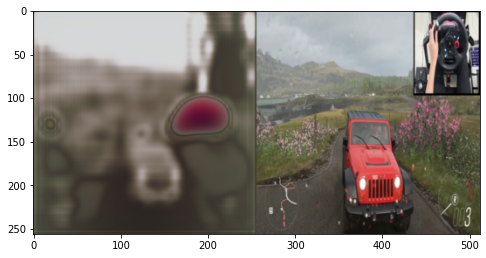

Epoch 0/3000, D_adv Loss: 0.6931473016738892, G_adv Loss: 0.6934956908226013, Pixel Loss: 97765.828125
Epoch 1/3000, Batch 0/104, D_Adv Loss: 0.6931472420692444, G_Adv Loss: 0.6934364438056946, Pixel Loss: 111999.421875, Perceptual Loss: 3.827995538711548
Epoch 1/3000, Batch 1/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6933692097663879, Pixel Loss: 117005.375, Perceptual Loss: 3.779109001159668
Epoch 1/3000, Batch 2/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6932980418205261, Pixel Loss: 118509.734375, Perceptual Loss: 3.9276435375213623
Epoch 1/3000, Batch 3/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6932263374328613, Pixel Loss: 120732.359375, Perceptual Loss: 4.013354778289795
Epoch 1/3000, Batch 4/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6931579113006592, Pixel Loss: 117023.171875, Perceptual Loss: 3.973384380340576
Epoch 1/3000, Batch 5/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.693095326423645, Pixel Loss: 111143.8359375, Perceptual Loss:

KeyboardInterrupt: ignored

In [11]:
print('Training Started...')
for epoch in range(epochs):
    for num, batch in enumerate(train_dataloader):
        if batch['X'].shape[0] == batch_size:

            hidden = my_unet._init_hidden(batch_size)
            optimizer.zero_grad()
            D_optim.zero_grad()
            
            adv_error = run_discriminator(batch, my_unet, discriminator, L_adv, in_frames, batch_size)

            adv_error.backward()
            D_optim.step()
            
            hidden = my_unet._init_hidden(batch_size)
            optimizer.zero_grad()
            D_optim.zero_grad()
            
            pixel_error, g_adv_error, perceptual_error, y_pred = run_generator(batch, my_unet, discriminator, L_adv, L_pixel, L_percept, in_frames, batch_size)
            
            error = pixel_error + g_adv_error
            error.backward()
            optimizer.step()

            print('Epoch {}/{}, Batch {}/{}, D_Adv Loss: {}, G_Adv Loss: {}, Pixel Loss: {}, Perceptual Loss: {}'.format(epoch, epochs, num, len(train_dataloader), adv_error.item(), g_adv_error.item(), pixel_error.item(), perceptual_error.item()))
            train_losses.append(pixel_error)

    if epoch % 10==0:
        test_error = 0
        for test_num, test_batch in enumerate(test_dataloader):
            if batch['X'].shape[0] == batch_size:
                hidden = my_unet._init_hidden(batch_size)
                optimizer.zero_grad()
                D_optim.zero_grad()

                adv_error = run_discriminator(batch, my_unet, discriminator, L_adv, in_frames, batch_size)

                hidden = my_unet._init_hidden(batch_size)
                optimizer.zero_grad()
                D_optim.zero_grad()
                
                pixel_error, g_adv_error, perceptual_error, y_pred= run_generator(batch, my_unet, discriminator, L_adv, L_pixel, L_percept, in_frames, batch_size)

        test_losses.append(pixel_error.item())
        print('Epoch {}/{}, Test Pixel Loss: {}, Test Perceptual Loss: {}, Test D_adv Loss: {}, Test G_adv Loss: {}'.format(epoch, epochs,pixel_error.item(), perceptual_error.item(), adv_error.item(), g_adv_error.item()) )
        
        plt.figure(figsize=(8,5))
        plt.imshow(prevTransforms(torch.cat([y_pred[0].cpu(), nnf.interpolate(test_batch['Y'], size=(512, 512), mode='bilinear', align_corners=False)[0].cpu()], axis=2)))
        plt.show()
                    
    print('Epoch {}/{}, D_adv Loss: {}, G_adv Loss: {}, Pixel Loss: {}'.format(epoch, epochs, adv_error.item(), g_adv_error.item(), pixel_error.item()))

**Save and Download Models from Colab**

In [15]:
torch.save(my_unet, 'unet_epoch_15')
torch.save(discriminator, 'D_epoch_15')
from google.colab import files
files.download('unet_epoch_15') 
files.download('D_epoch_15') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Started...
Epoch 16/3000, Batch 0/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6931471824645996, Pixel Loss: 17774.912109375, Perceptual Loss: 2.1185295581817627
Epoch 16/3000, Batch 1/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6931471824645996, Pixel Loss: 20747.05859375, Perceptual Loss: 2.5865352153778076
Epoch 16/3000, Batch 2/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6931471824645996, Pixel Loss: 21154.3125, Perceptual Loss: 2.394829034805298
Epoch 16/3000, Batch 3/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6931471824645996, Pixel Loss: 27473.33203125, Perceptual Loss: 2.4338107109069824
Epoch 16/3000, Batch 4/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6931472420692444, Pixel Loss: 22606.64453125, Perceptual Loss: 2.2285470962524414
Epoch 16/3000, Batch 5/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6931471824645996, Pixel Loss: 19498.765625, Perceptual Loss: 2.103475332260132
Epoch 16/3000, Batch 6/104, D_Adv Loss: 0.693147182

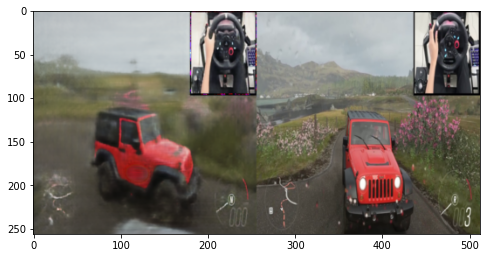

Epoch 20/3000, D_adv Loss: 0.6931471824645996, G_adv Loss: 0.6931471824645996, Pixel Loss: 16621.58984375
Epoch 21/3000, Batch 0/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6931471824645996, Pixel Loss: 17123.783203125, Perceptual Loss: 2.118926525115967
Epoch 21/3000, Batch 1/104, D_Adv Loss: 0.6931471228599548, G_Adv Loss: 0.6931471824645996, Pixel Loss: 17928.19921875, Perceptual Loss: 2.1602792739868164
Epoch 21/3000, Batch 2/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6931471824645996, Pixel Loss: 23613.390625, Perceptual Loss: 2.3698160648345947
Epoch 21/3000, Batch 3/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6931471824645996, Pixel Loss: 15313.00390625, Perceptual Loss: 1.76829195022583
Epoch 21/3000, Batch 4/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6931471824645996, Pixel Loss: 15390.123046875, Perceptual Loss: 2.0209708213806152
Epoch 21/3000, Batch 5/104, D_Adv Loss: 0.6931471824645996, G_Adv Loss: 0.6931472420692444, Pixel Loss: 17564.3691406

In [ ]:
print('Training Started...')
for epoch in range(16, epochs):
    for num, batch in enumerate(train_dataloader):
        if batch['X'].shape[0] == batch_size:

            hidden = my_unet._init_hidden(batch_size)
            optimizer.zero_grad()
            D_optim.zero_grad()
            
            adv_error = run_discriminator(batch, my_unet, discriminator, L_adv, in_frames, batch_size)

            adv_error.backward()
            D_optim.step()
            
            hidden = my_unet._init_hidden(batch_size)
            optimizer.zero_grad()
            D_optim.zero_grad()
            
            pixel_error, g_adv_error, perceptual_error, y_pred = run_generator(batch, my_unet, discriminator, L_adv, L_pixel, L_percept, in_frames, batch_size)
            
            error = pixel_error + g_adv_error
            error.backward()
            optimizer.step()

            print('Epoch {}/{}, Batch {}/{}, D_Adv Loss: {}, G_Adv Loss: {}, Pixel Loss: {}, Perceptual Loss: {}'.format(epoch, epochs, num, len(train_dataloader), adv_error.item(), g_adv_error.item(), pixel_error.item(), perceptual_error.item()))
            train_losses.append(pixel_error)

    if epoch % 10==0:
        for test_num, test_batch in enumerate(test_dataloader):
            if batch['X'].shape[0] == batch_size:
                hidden = my_unet._init_hidden(batch_size)
                optimizer.zero_grad()
                D_optim.zero_grad()

                adv_error = run_discriminator(batch, my_unet, discriminator, L_adv, in_frames, batch_size)

                hidden = my_unet._init_hidden(batch_size)
                optimizer.zero_grad()
                D_optim.zero_grad()
                
                pixel_error, g_adv_error, perceptual_error, y_pred= run_generator(batch, my_unet, discriminator, L_adv, L_pixel, L_percept, in_frames, batch_size)

        test_losses.append(pixel_error.item())
        print('Epoch {}/{}, Test Pixel Loss: {}, Test Perceptual Loss: {}, Test D_adv Loss: {}, Test G_adv Loss: {}'.format(epoch, epochs,pixel_error.item(), perceptual_error.item(), adv_error.item(), g_adv_error.item()) )
        
        plt.figure(figsize=(8,5))
        plt.imshow(prevTransforms(torch.cat([y_pred[0].cpu(), nnf.interpolate(test_batch['Y'], size=(512, 512), mode='bilinear', align_corners=False)[0].cpu()], axis=2)))
        plt.show()
                    
    print('Epoch {}/{}, D_adv Loss: {}, G_adv Loss: {}, Pixel Loss: {}'.format(epoch, epochs, adv_error.item(), g_adv_error.item(), pixel_error.item()))

**Show example of Generated Image vs Actual Image**

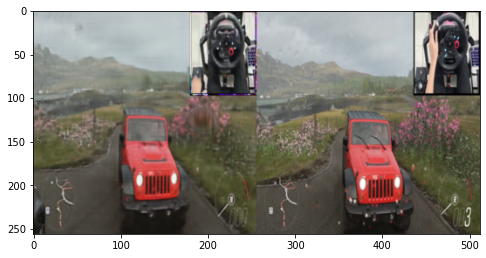

In [16]:
plt.figure(figsize=(8,5))
plt.imshow(prevTransforms(torch.cat([y_pred[0].cpu(), nnf.interpolate(test_batch['Y'].cpu(), size=(512, 512), mode='bilinear', align_corners=False)[0]], axis=2)))
plt.show()

**Show example of Foveated Image vs Generated Image**

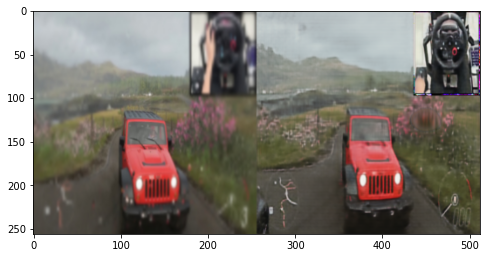

In [21]:
plt.figure(figsize=(8,5))
plt.imshow(prevTransforms( torch.cat([nnf.interpolate(test_batch['X'].cpu(), size=(512, 512), mode='bilinear', align_corners=False)[0][-3:], y_pred[0].cpu()], axis=2)))
plt.show()

In [98]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained=True)
model

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 